In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import scipy as sp
import scipy.io as io
import matplotlib.pyplot as plt
from pyfinance import ols
# alpha is constant, beta[:,0] is slope

import sys
sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV/')

from neurodsp import spectral
import neurodsp as ndsp

In [103]:
def plot_psdscv(f_axis, psd, scv, plot_chans=None):    
    # plot PSD & SCV
    if plot_chans is None:
        plot_chans = np.arange(psd.shape[0])

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.loglog(f_axis[:300],psd[plot_chans,:300].T, alpha=0.5, lw=0.5);

    plt.subplot(1,2,2)
    plt.loglog(f_axis[:300], scv[plot_chans, :300].T, alpha=0.5, lw=0.5)
    plt.plot([1,500], [1,1], 'k')
    plt.ylim([0.5, 4])
    plt.tight_layout()

In [125]:
def rols_spectral_fit(f_axis, psd, scv, winlen=10, fit_range=(1,200), exclu_range=None, thres_rad=0.1, do_plot=True):    
    f_inds = np.where(np.logical_and(f_axis>=fit_range[0],f_axis<=fit_range[1]))[0]
    if exclu_range is not None:
        # take out some frequencies
        f_exclu_inds = np.where(np.logical_and(f_axis>=exclu_range[0],f_axis<=exclu_range[1]))[0]
        f_inds = np.setdiff1d(f_inds, f_exclu_inds)

    x = f_axis[f_inds]
    y = [psd[f_inds],scv[f_inds]]

    # plotting SCV slope vs. PSD fit R^2
    psd_model = ols.RollingOLS(y=np.log10(y[0]), x=np.log10(x), window=20, has_const=False, use_const=True)
    scv_model = ols.RollingOLS(y=np.log10(y[1]), x=np.log10(x), window=20, has_const=False, use_const=True)

    rad = (scv_model.alpha**2+scv_model.beta[:,0]**2)**0.5
    in_rad = rad<thres_rad
    
    if do_plot:
        fit_inds = range(int(winlen/2),int(len(psd_model.alpha)+winlen/2))
        x_axis = x[fit_inds]

        plt.figure(figsize=(12,8))

        plt.subplot(2,3,1)
        plt.loglog(x,y[1],'k')
        plt.loglog(x_axis,y[1][fit_inds])
        plt.loglog(x_axis[in_rad],y[1][fit_inds][in_rad],'r.')
        plt.plot(x_axis[[0,-1]], [1,1], 'k-')
        plt.title('SCV')

        plt.subplot(2,3,4)
        plt.loglog(x,y[0],'k')
        plt.loglog(x_axis,y[0][fit_inds])
        plt.loglog(x_axis[in_rad],y[0][fit_inds][in_rad],'r.')
        plt.title('PSD')

        # SCV offset vs. SCV slope, looking for origin
        h1=plt.subplot(2,3,2)
        plt.plot(scv_model.alpha,scv_model.beta, '.')
        plt.plot(scv_model.alpha[in_rad],scv_model.beta[in_rad,0], 'r.')
        h1.add_artist(plt.Circle((0,0), thres_rad, color='k', fill=False))
        plt.title('SCV offset vs. SCV slope: rad=%.3f' %thres_rad)

        plt.subplot(2,3,3)
        plt.semilogx(x_axis, rad)
        plt.semilogx(x_axis[in_rad], rad[in_rad], '.r')
        plt.plot(x_axis[[0, -1]], [thres_rad,thres_rad],'-k')
        plt.title('SCV (offset,slope) radius')

        # PSD slope
        plt.subplot(2,3,5)
        plt.semilogx(x_axis,psd_model.beta)
        plt.semilogx(x_axis[in_rad],psd_model.beta[in_rad,0], '.r')
        plt.title('PSD rolling slope')

        plt.subplot(2,3,6)
        plt.semilogx(x_axis,psd_model.rsq)
        plt.semilogx(x_axis[in_rad],psd_model.rsq[in_rad], '.r')
        plt.title('PSD rolling fit error')
        plt.tight_layout()    

### PFC-2 dataset 
rat hippocampus and pfc LFP

In [7]:
data = io.loadmat('/Users/rdgao/Documents/Data/CRCNS/pfc2/EE.049/lfp_EE049.mat', squeeze_me=True)
lfp = data['data']
fs = data['fs']
t = data['t']
data.keys()

In [9]:
# compute PSD & SCV
f_lfp, psd = spectral.psd(lfp, fs)
scv = []
for chan in range(48):
    f_lfp, scv_lfp = spectral.scv(lfp[chan,:], fs, outlierpct=1.)
    scv.append(scv_lfp)

scv = np.vstack(scv)

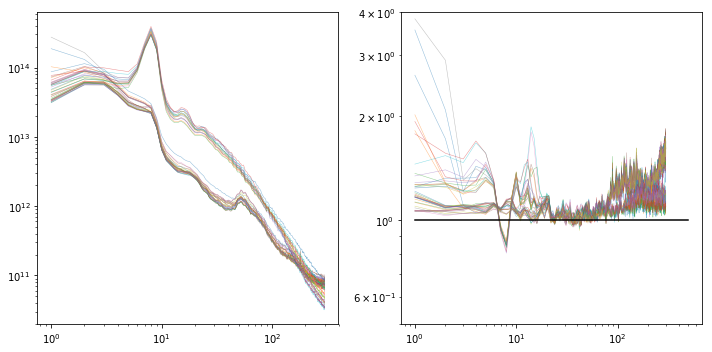

In [10]:
# plot PSD & SCV
plot_chans = np.concatenate((np.arange(0,14), np.arange(16,23), np.arange(24,48)))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(f_lfp[:300],psd[plot_chans,:300].T, alpha=0.5, lw=0.5);

plt.subplot(1,2,2)
plt.loglog(f_lfp[:300], scv[plot_chans, :300].T, alpha=0.5, lw=0.5)
plt.plot([1,500], [1,1], 'k')
plt.ylim([0.5, 4])
plt.tight_layout()

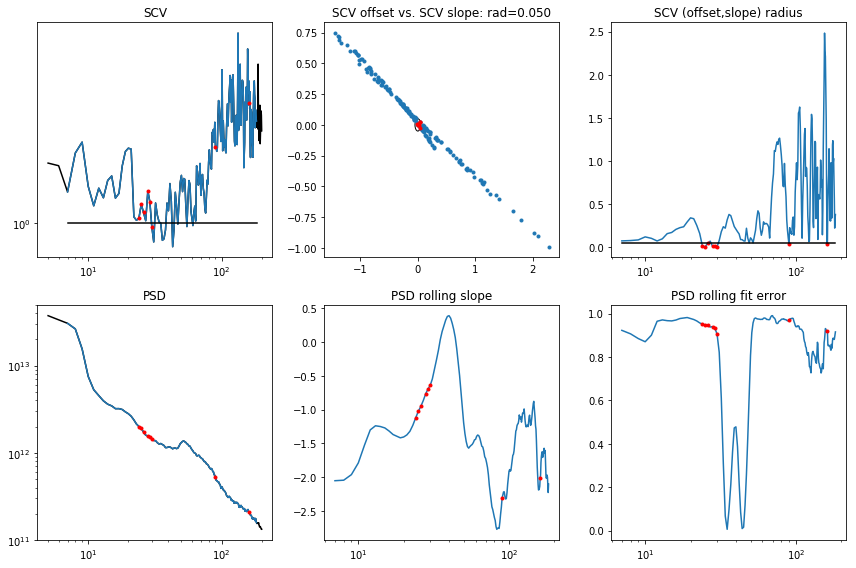

In [80]:
chan = 5
rols_spectral_fit(f_lfp, psd[chan,:], scv[chan,:], winlen=5, fit_range=(5,200), thres_rad=0.05, do_plot=True)

### HC-2 Dataset
rat hippocampus LFP

In [83]:
data = io.loadmat('/Users/rdgao/Documents/Data/CRCNS/hc2/Raw/lfp_spiketimes_ec013.527.mat', squeeze_me=True)
data.keys()
lfp = data['data']
spk_fs = data['spk_binrate']
bsp = data['bsp']
fs = data['srate']

In [86]:
lfp.shape

(31, 1325125)

In [87]:
# compute PSD & SCV
f_lfp, psd = spectral.psd(lfp, fs)
scv = []
for chan in range(lfp.shape[0]):
    f_lfp, scv_lfp = spectral.scv(lfp[chan,:], fs, outlierpct=1.)
    scv.append(scv_lfp)

scv = np.vstack(scv)

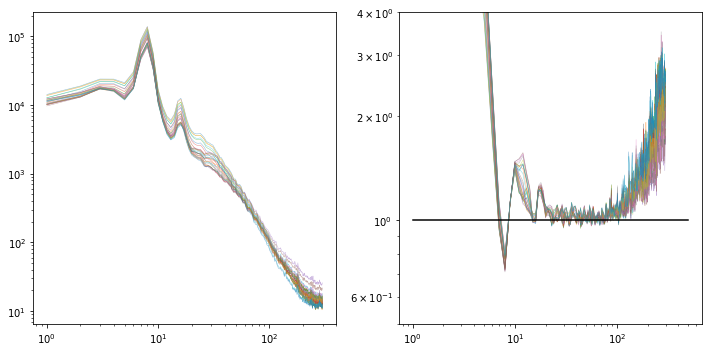

In [89]:
# plot PSD & SCV
plot_chans = np.arange(lfp.shape[0])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(f_lfp[:300],psd[plot_chans,:300].T, alpha=0.5, lw=0.5);

plt.subplot(1,2,2)
plt.loglog(f_lfp[:300], scv[plot_chans, :300].T, alpha=0.5, lw=0.5)
plt.plot([1,500], [1,1], 'k')
plt.ylim([0.5, 4])
plt.tight_layout()

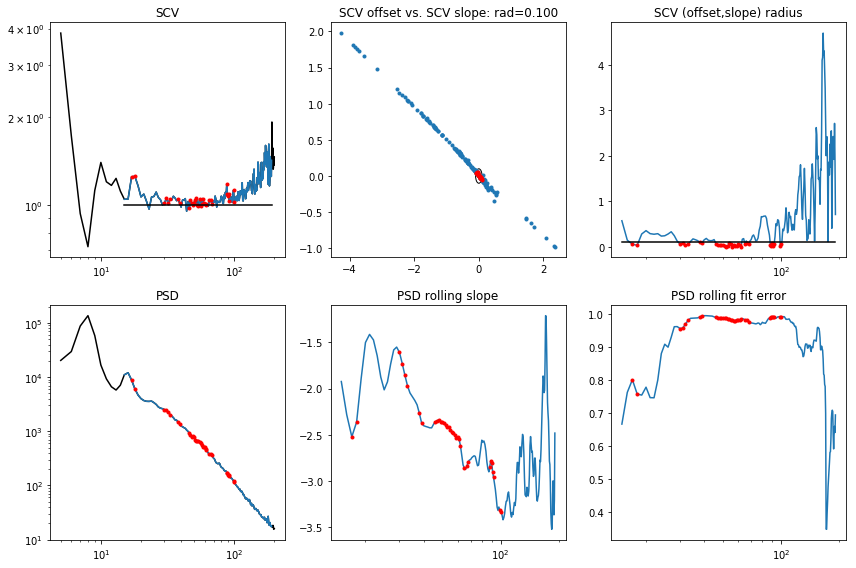

In [94]:
chan = 1
rols_spectral_fit(f_lfp, psd[chan,:], scv[chan,:], winlen=20, fit_range=(5,200), thres_rad=0.1, do_plot=True)

### KJM digit task ECoG
cortical ECoG

In [96]:
data_path = '/Users/rdgao/Documents/Data/ECoG_KJM/digit/'
subjs = ['bp', 'cc', 'ht', 'jc', 'jp', 'mv', 'wc', 'wm', 'zt']

subj = subjs[0]
print(subj)
data = io.loadmat(data_path+'data/'+subj+'/'+subj+'_fingerflex.mat', squeeze_me=True)
ecog = data['data'].T
fs = 1000.
num_chan,num_samp = np.shape(ecog)
print(num_chan)

bp
46


In [106]:
# compute PSD & SCV
f_lfp, psd = spectral.psd(ecog, fs)
scv = []
for chan in range(ecog.shape[0]):
    f_lfp, scv_lfp = spectral.scv(ecog[chan,:], fs, outlierpct=1.)
    scv.append(scv_lfp)

scv = np.vstack(scv)

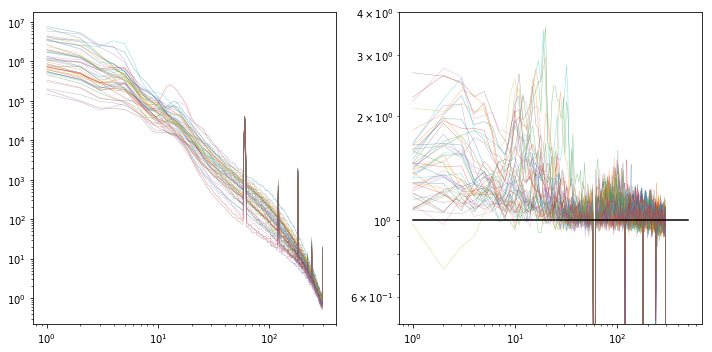

In [107]:
plot_psdscv(f_lfp, psd, scv)

Channel: 0


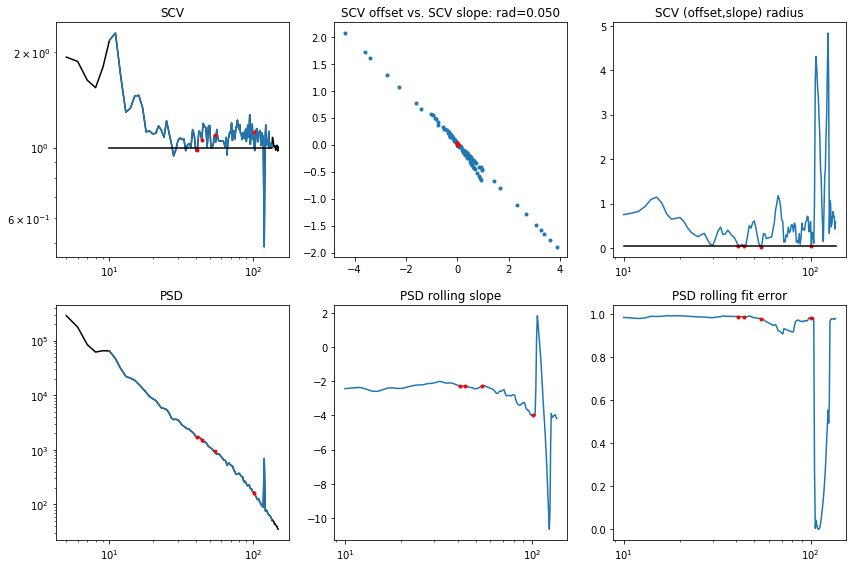

Press Enter to continue...
Channel: 1


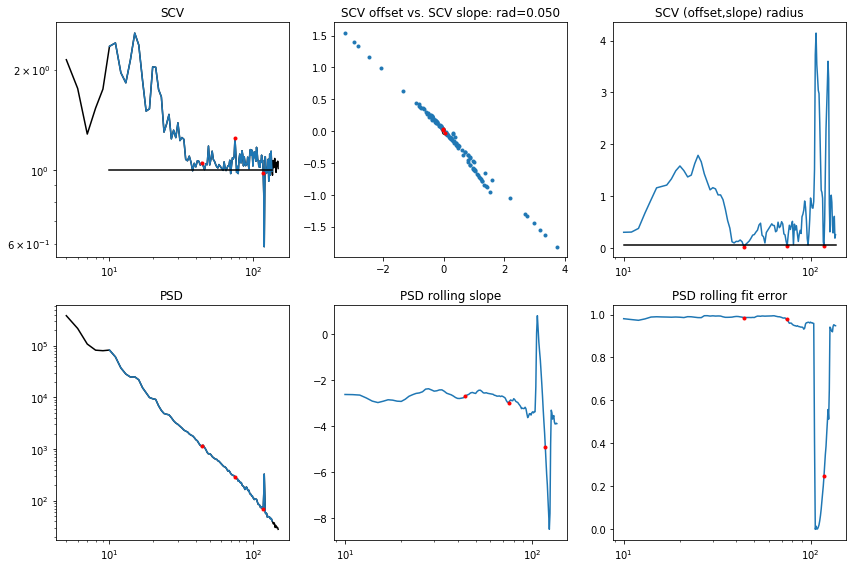

Press Enter to continue...
Channel: 2


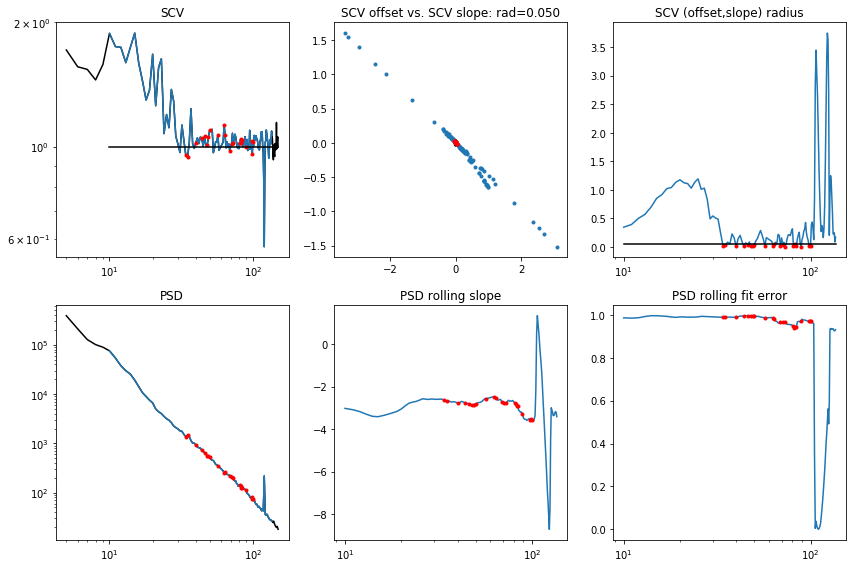

Press Enter to continue...
Channel: 3


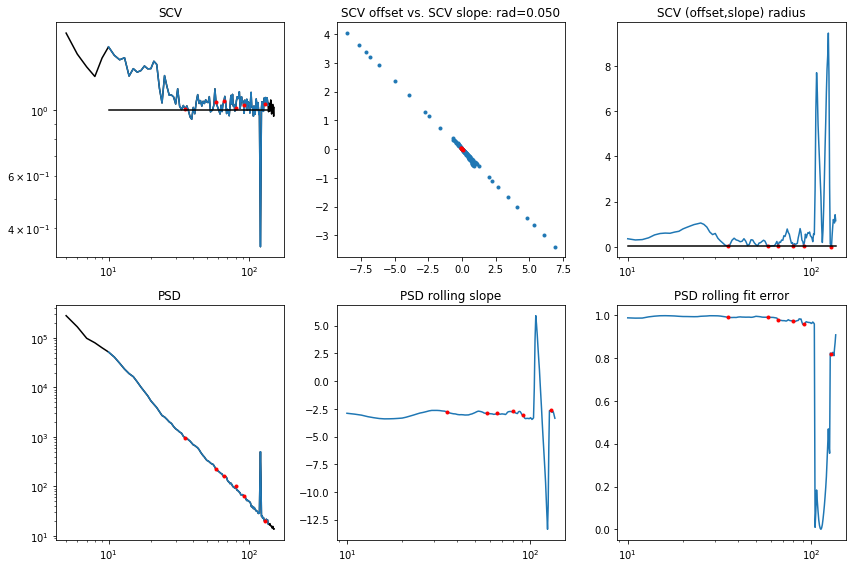

Press Enter to continue...
Channel: 4


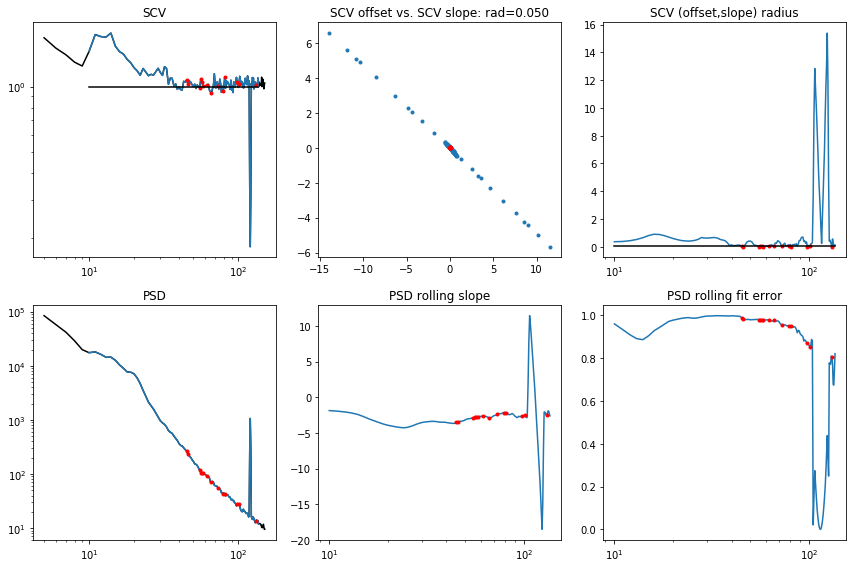

Press Enter to continue...
Channel: 5


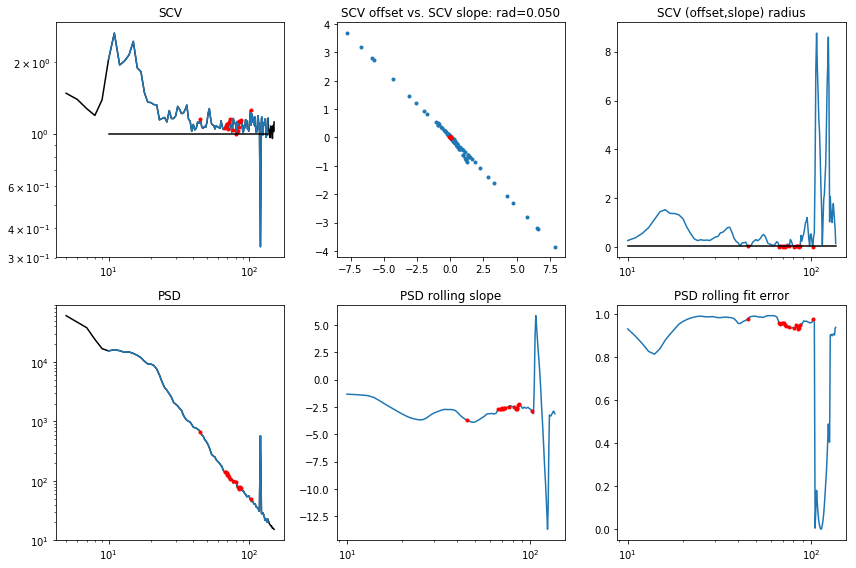

Press Enter to continue...
Channel: 6


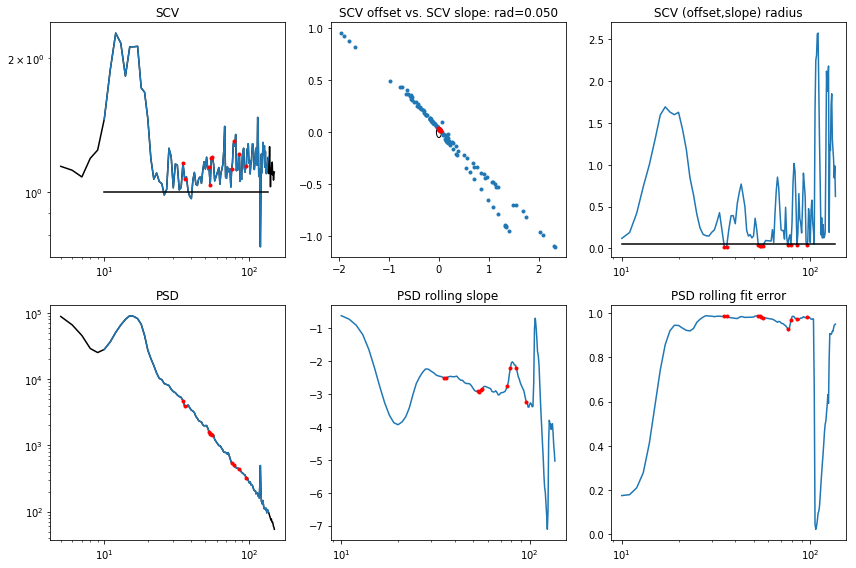

Press Enter to continue...
Channel: 7


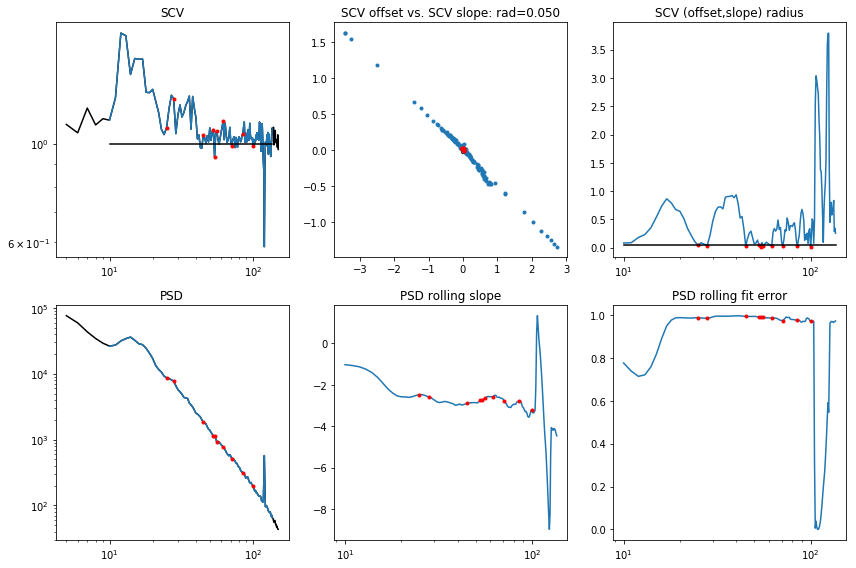

Press Enter to continue...
Channel: 8


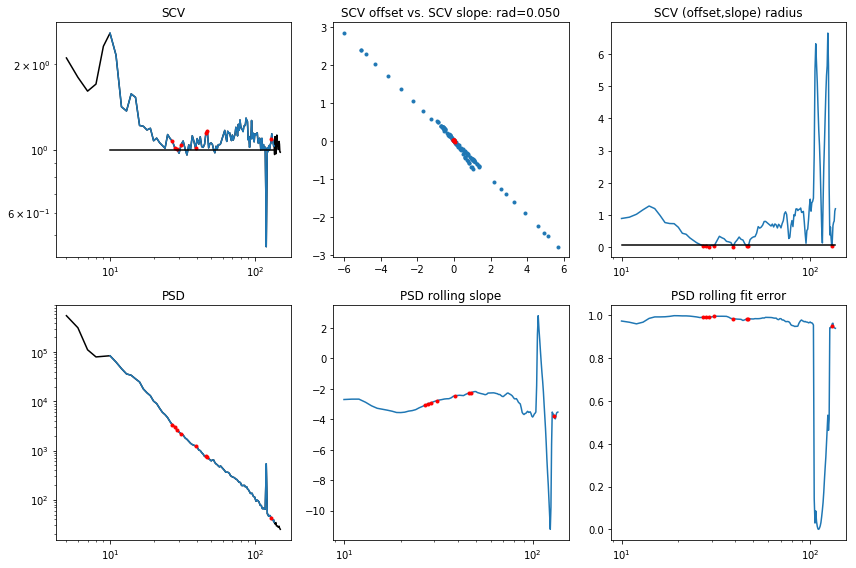

Press Enter to continue...
Channel: 9


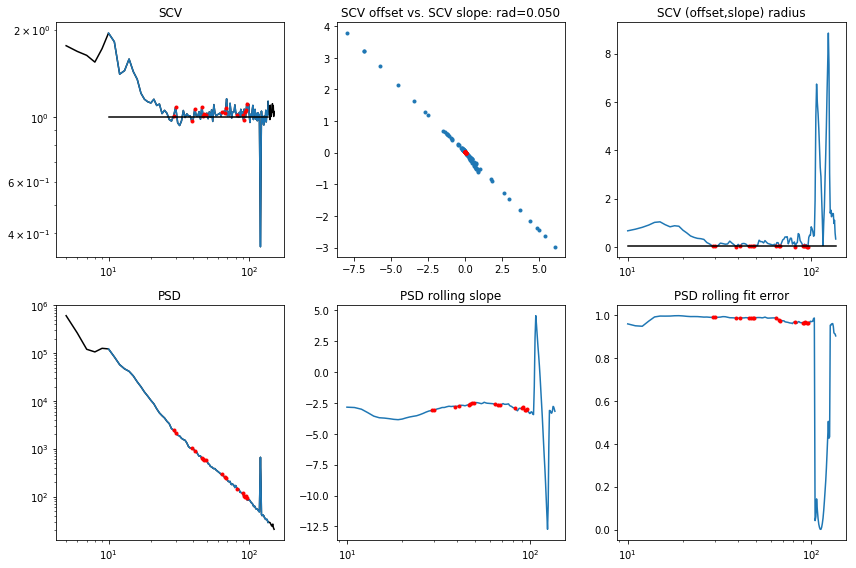

Press Enter to continue...
Channel: 10


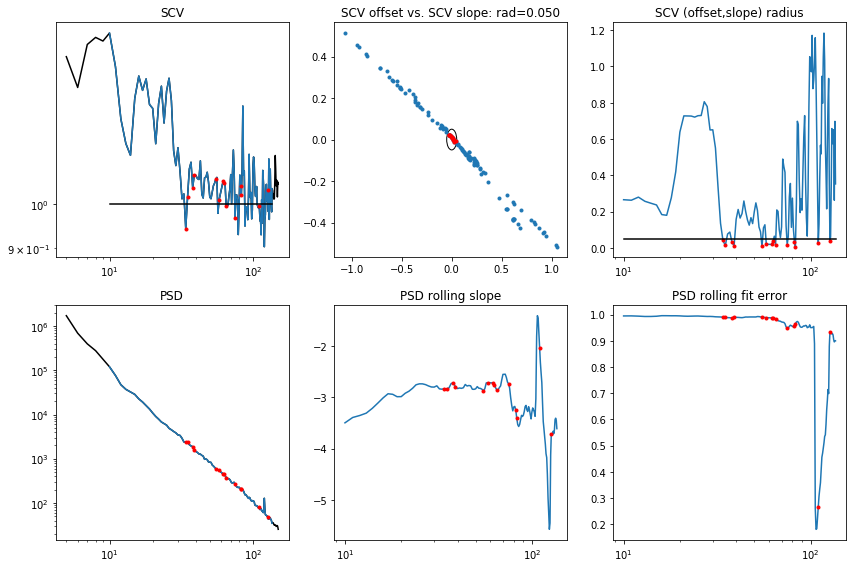

Press Enter to continue...
Channel: 11


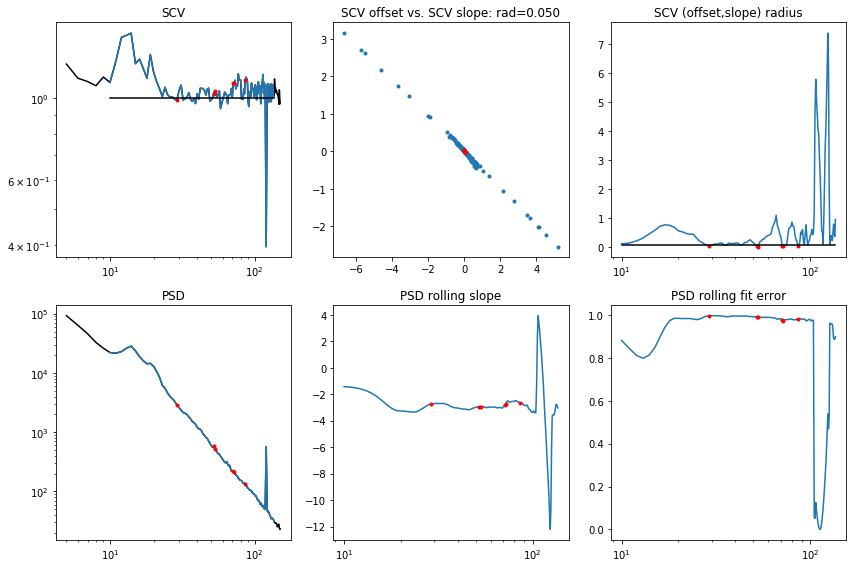

Press Enter to continue...
Channel: 12


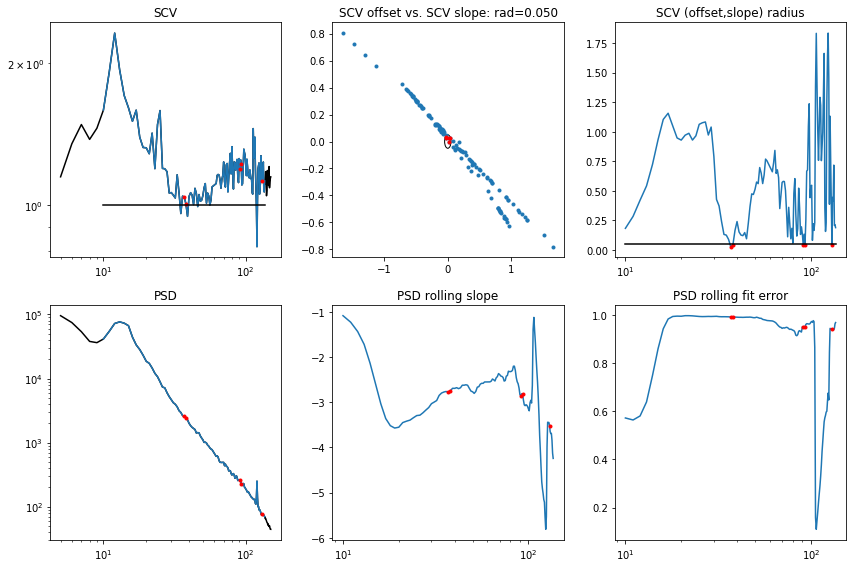

In [ ]:
for chan in range(psd.shape[0]):
    print('Channel: %i'%chan)
    rols_spectral_fit(f_lfp, psd[chan,:], scv[chan,:], winlen=10, fit_range=(5,150), exclu_range=(59, 61), thres_rad=0.05, do_plot=True)
    plt.show()
    input("Press Enter to continue...")